In [8]:
!pip install shap

In [11]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [12]:
import os
import shap
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from modeling import FoldSet, GridSearch_ML, MLTest
from rnn_modeling import Make_DataSet
from correlation import Correlation
from visualization import Result_pred, Plot_Result, Monthly_plot, TimeBar

# Load data

In [13]:
df = pd.read_csv('/content/gdrive/MyDrive/SolarPower/Mpdata.csv')
print(df.shape)
df

(26192, 14)


,Date,Area,Time,Photovoltaics,PM10,Temperature,Wind velocity,Wind direction,Humidity,Sea-level pressure,Solar radiation,Cloudy,Visibility,Month
0,2013-01-01,전남 목포시,9,20.16,43.0,2.6,6.0,290.0,91.0,1019.6,0.03,10.0,1300.0,1
1,2013-01-01,전남 목포시,10,106.80,56.0,4.2,5.8,250.0,82.0,1019.9,0.57,7.0,1300.0,1
2,2013-01-01,전남 목포시,11,469.56,75.0,3.8,7.1,320.0,80.0,1020.5,1.00,9.0,1300.0,1
3,2013-01-01,전남 목포시,12,504.24,84.0,4.9,2.8,290.0,73.0,1020.1,1.05,7.0,1300.0,1
4,2013-01-01,전남 목포시,13,745.20,78.0,5.2,6.7,320.0,66.0,1019.7,1.14,6.0,1100.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26187,2019-12-31,전남 목포시,14,1148.52,24.0,-1.5,9.1,360.0,59.0,1033.5,1.04,7.0,2000.0,12
26188,2019-12-31,전남 목포시,15,830.88,21.0,-1.5,9.9,360.0,55.0,1033.6,1.43,6.0,2000.0,12
26189,2019-12-31,전남 목포시,16,550.92,20.0,-1.7,8.9,360.0,60.0,1034.0,0.86,7.0,2000.0,12
26190,2019-12-31,전남 목포시,17,74.28,22.0,-1.9,8.8,360.0,61.0,1034.3,0.39,6.0,2000.0,12


In [14]:
df['Area'].unique()

array(['전남 목포시'], dtype=object)

# Create Deviation Variable

In [15]:
cols = [x for x in df.columns if x not in ['Date','Area','Month','Time']]
cols

['Photovoltaics',
 'PM10',
 'Temperature',
 'Wind velocity',
 'Wind direction',
 'Humidity',
 'Sea-level pressure',
 'Solar radiation',
 'Cloudy',
 'Visibility']

In [16]:
testmn, x_train, y_train, x_test, y_test = Make_DataSet(df, 'ML', dev=True)

Train-set:  dev_PM10, dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Solar radiation, dev_Cloudy, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_PM10, dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Solar radiation, dev_Cloudy, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (21894, 9), (21894, 1) test: (4298, 9), (4298, 1)



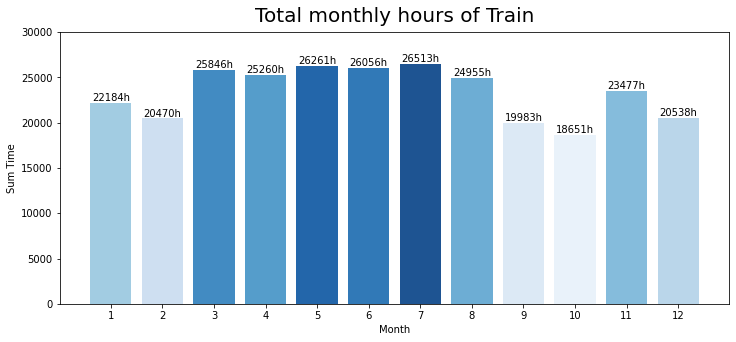

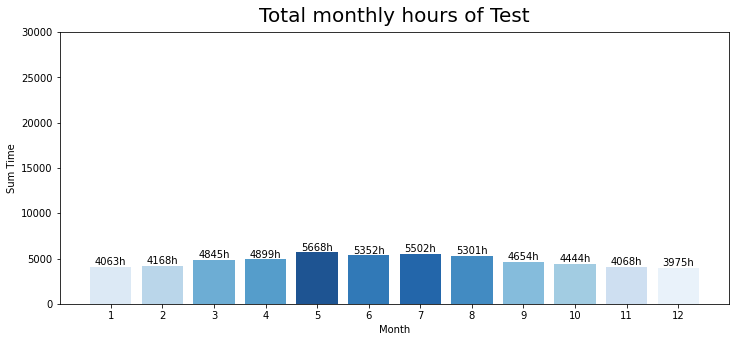

In [17]:
TimeBar(df.loc[:21894-1], '전남 목포시', 'Train', [0,30000])
TimeBar(df.loc[21894:], '전남 목포시', 'Test', [0,30000])

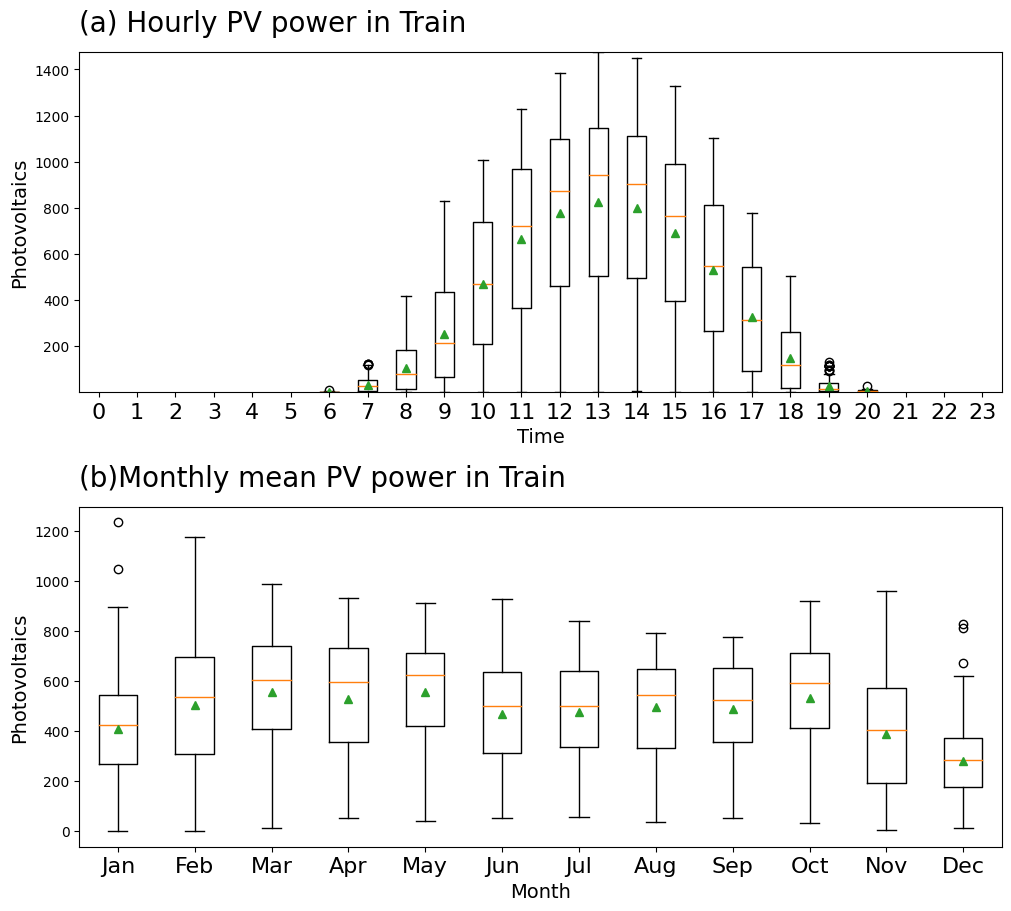

In [18]:
Monthly_plot(df.loc[:21894-1], 'Photovoltaics', 'Train')

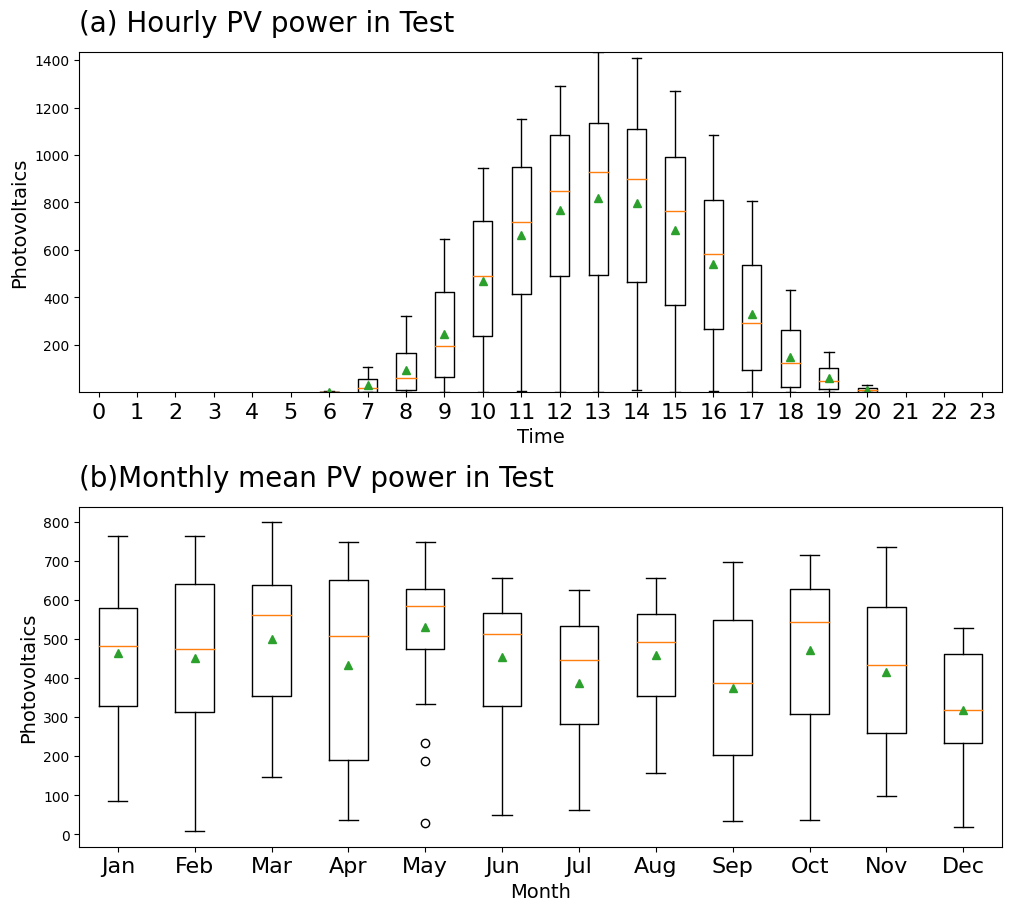

In [19]:
Monthly_plot(df.loc[21894:], 'Photovoltaics', 'Test')

In [20]:
train_Mokpo = pd.concat([x_train, y_train], axis=1)
train_Mokpo

,dev_PM10,dev_Temperature,dev_Wind velocity,dev_Wind direction,dev_Humidity,dev_Sea-level pressure,dev_Solar radiation,dev_Cloudy,dev_Visibility,dev_Photovoltaics
0,-2.496894,2.518012,3.383851,142.236025,9.701863,-6.996894,-0.169006,4.571429,16.428571,-25.316273
1,9.329193,2.727329,2.640994,98.633540,5.229814,-6.872671,-0.001242,1.956522,-41.596273,-140.381366
2,27.464968,1.204459,3.477707,121.847134,7.063694,-6.135669,0.066624,4.178344,-77.732484,-50.734013
3,33.888199,1.326708,-1.268944,52.111801,3.204969,-5.832298,-0.146335,2.534161,-120.832298,-236.786087
4,31.204969,0.924224,2.278882,79.192547,-1.534161,-5.348447,-0.174596,1.279503,-337.409938,-61.041988
...,...,...,...,...,...,...,...,...,...,...
21889,0.489510,-5.925175,2.169930,-184.545455,-0.720280,11.234266,0.791818,-5.748252,-65.748252,515.415944
21890,5.337838,-5.204054,3.353378,111.216216,-2.135135,11.086486,0.689054,-5.594595,210.722973,370.349189
21891,0.188312,-4.948701,2.055844,112.402597,-10.409091,11.097403,0.512922,-5.564935,355.636364,295.064416
21892,-8.238710,-4.724516,2.276774,-194.903226,-10.238710,11.200000,0.280516,-5.748387,433.516129,40.320000


In [21]:
train_Mokpo.columns

Index(['dev_PM10', 'dev_Temperature', 'dev_Wind velocity',
       'dev_Wind direction', 'dev_Humidity', 'dev_Sea-level pressure',
       'dev_Solar radiation', 'dev_Cloudy', 'dev_Visibility',
       'dev_Photovoltaics'],
      dtype='object')

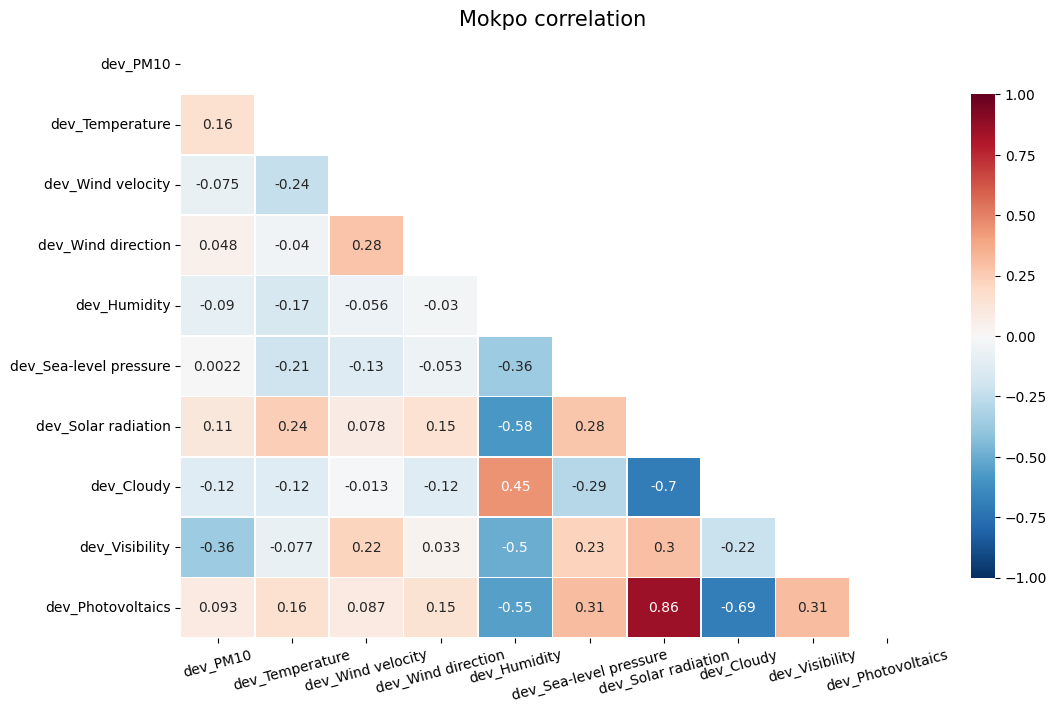

In [22]:
c = Correlation(train_Mokpo, train_Mokpo.columns, 'Mokpo')

# Fine-tuning the model

In [23]:
params = {}

In [ ]:
params = GridSearch_ML(df, cols, params, dev=True)
params = GridSearch_ML(df, cols, params)

In [25]:
for k,v in params.items():
  print(k,v)

dev_MLP {'activation': 'logistic', 'hidden_layer_sizes': (300,), 'learning_rate': 'adaptive', 'max_iter': 3000, 'solver': 'adam'}
dev_LGBM {'boosting': 'gbdt', 'learning_rate': 0.1, 'max_depth': -1, 'metric': 'mse', 'num_leaves': 10, 'objective': 'regression'}
ori_MLP {'activation': 'logistic', 'hidden_layer_sizes': (400,), 'learning_rate': 'constant', 'max_iter': 3000, 'solver': 'adam'}
ori_LGBM {'boosting': 'gbdt', 'learning_rate': 0.1, 'max_depth': 5, 'metric': 'mse', 'num_leaves': 10, 'objective': 'regression'}


# Model Learning

## LR 
(LinearRegression)

In [26]:
# score점수 저장
score = {}
# shap plot을 위한 값 저장
Shap_dic = {}

In [27]:
pred_LR = MLTest(df, 'LR', params, score, Shap_dic, dev=True)

Train-set:  dev_PM10, dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Solar radiation, dev_Cloudy, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_PM10, dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Solar radiation, dev_Cloudy, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (21894, 9), (21894, 1) test: (4298, 9), (4298, 1)

train: (3649, 9), (3649, 1) valid: (3649, 9), (3649, 1)

train: (7298, 9), (7298, 1) valid: (3649, 9), (3649, 1)

train: (10947, 9), (10947, 1) valid: (3649, 9), (3649, 1)

train: (14596, 9), (14596, 1) valid: (3649, 9), (3649, 1)

train: (18245, 9), (18245, 1) valid: (3649, 9), (3649, 1)

LinearRegression()


In [28]:
ignore = MLTest(df, 'LR', params, score, Shap_dic)

Train-set:  PM10, Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Solar radiation, Cloudy, Visibility Index(['Photovoltaics'], dtype='object') 
Test-set :  PM10, Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Solar radiation, Cloudy, Visibility Index(['Photovoltaics'], dtype='object')
train: (21894, 9), (21894, 1) test: (4298, 9), (4298, 1)

train: (3649, 9), (3649, 1) valid: (3649, 9), (3649, 1)

train: (7298, 9), (7298, 1) valid: (3649, 9), (3649, 1)

train: (10947, 9), (10947, 1) valid: (3649, 9), (3649, 1)

train: (14596, 9), (14596, 1) valid: (3649, 9), (3649, 1)

train: (18245, 9), (18245, 1) valid: (3649, 9), (3649, 1)

LinearRegression()


## MLP 
(MLPRegressor)

In [29]:
pred_MLP = MLTest(df, 'MLP', params, score, Shap_dic, dev=True)

Train-set:  dev_PM10, dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Solar radiation, dev_Cloudy, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_PM10, dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Solar radiation, dev_Cloudy, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (21894, 9), (21894, 1) test: (4298, 9), (4298, 1)

train: (3649, 9), (3649, 1) valid: (3649, 9), (3649, 1)

train: (7298, 9), (7298, 1) valid: (3649, 9), (3649, 1)

train: (10947, 9), (10947, 1) valid: (3649, 9), (3649, 1)

train: (14596, 9), (14596, 1) valid: (3649, 9), (3649, 1)

train: (18245, 9), (18245, 1) valid: (3649, 9), (3649, 1)

MLPRegressor(activation='logistic', hidden_layer_sizes=(300,),
             learning_rate='adaptive', max_iter=3000)


In [30]:
ignore = MLTest(df, 'MLP', params, score, Shap_dic)

Train-set:  PM10, Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Solar radiation, Cloudy, Visibility Index(['Photovoltaics'], dtype='object') 
Test-set :  PM10, Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Solar radiation, Cloudy, Visibility Index(['Photovoltaics'], dtype='object')
train: (21894, 9), (21894, 1) test: (4298, 9), (4298, 1)

train: (3649, 9), (3649, 1) valid: (3649, 9), (3649, 1)

train: (7298, 9), (7298, 1) valid: (3649, 9), (3649, 1)

train: (10947, 9), (10947, 1) valid: (3649, 9), (3649, 1)

train: (14596, 9), (14596, 1) valid: (3649, 9), (3649, 1)

train: (18245, 9), (18245, 1) valid: (3649, 9), (3649, 1)

MLPRegressor(activation='logistic', hidden_layer_sizes=(400,), max_iter=3000)


## LGBM
 (LGBMRegressor)

In [31]:
pred_LGBM = MLTest(df, 'LGBM', params, score, Shap_dic, dev=True)

Train-set:  dev_PM10, dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Solar radiation, dev_Cloudy, dev_Visibility Index(['dev_Photovoltaics'], dtype='object') 
Test-set :  dev_PM10, dev_Temperature, dev_Wind velocity, dev_Wind direction, dev_Humidity, dev_Sea-level pressure, dev_Solar radiation, dev_Cloudy, dev_Visibility Index(['Photovoltaics'], dtype='object')
train: (21894, 9), (21894, 1) test: (4298, 9), (4298, 1)

train: (3649, 9), (3649, 1) valid: (3649, 9), (3649, 1)

train: (7298, 9), (7298, 1) valid: (3649, 9), (3649, 1)

train: (10947, 9), (10947, 1) valid: (3649, 9), (3649, 1)

train: (14596, 9), (14596, 1) valid: (3649, 9), (3649, 1)

train: (18245, 9), (18245, 1) valid: (3649, 9), (3649, 1)



In [32]:
ignore = MLTest(df, 'LGBM', params, score, Shap_dic)

Train-set:  PM10, Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Solar radiation, Cloudy, Visibility Index(['Photovoltaics'], dtype='object') 
Test-set :  PM10, Temperature, Wind velocity, Wind direction, Humidity, Sea-level pressure, Solar radiation, Cloudy, Visibility Index(['Photovoltaics'], dtype='object')
train: (21894, 9), (21894, 1) test: (4298, 9), (4298, 1)

train: (3649, 9), (3649, 1) valid: (3649, 9), (3649, 1)

train: (7298, 9), (7298, 1) valid: (3649, 9), (3649, 1)

train: (10947, 9), (10947, 1) valid: (3649, 9), (3649, 1)

train: (14596, 9), (14596, 1) valid: (3649, 9), (3649, 1)

train: (18245, 9), (18245, 1) valid: (3649, 9), (3649, 1)



# Score

In [33]:
score

{'R2_dev_LR': 0.8763361093970231,
 'RMSE_dev_LR': 137.16026604743308,
 'R2_LR': 0.804573159321373,
 'RMSE_LR': 172.4244985114788,
 'R2_dev_MLP': 0.8901918773174026,
 'RMSE_dev_MLP': 129.2480797121935,
 'R2_MLP': 0.8495657049236846,
 'RMSE_MLP': 151.27957425487875,
 'R2_dev_LGBM': 0.8924130249804746,
 'RMSE_dev_LGBM': 127.93421667839267,
 'R2_LGBM': 0.8640039573560732,
 'RMSE_LGBM': 143.83679632229644}

In [34]:
with open('/content/gdrive/MyDrive/SolarPower/Mokpo_score.txt','w',encoding='UTF-8') as f:
  for key, values in score.items():
    f.write(f'{key}:{values}\n')

# Shap plot

In [35]:
# 모델 학습 후 shap 생성 함수
def ShapPlot(model, x_train, model_name):
  shap.initjs()
  explainer = shap.Explainer(model.predict, x_train) 
  shap_values = explainer(x_train)

  shap.summary_plot(shap_values, x_train, plot_size=0.3, plot_type='bar', show=False)
  plt.title(f"{model_name} Shap barplot", fontsize=15, pad=10)
  plt.show()
  shap.summary_plot(shap_values, x_train, plot_size=0.4, show=False)
  plt.title(f"{model_name} Shap plot", fontsize=15, pad=10)
  plt.show()

Exact explainer: 21895it [05:18, 67.40it/s]                           


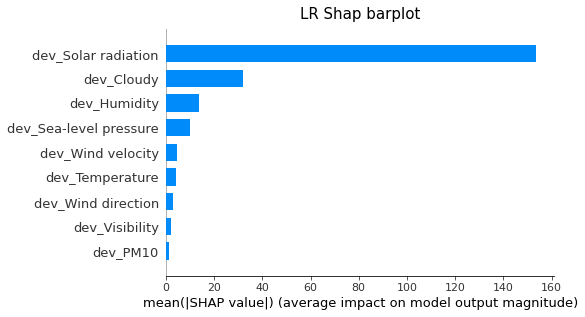

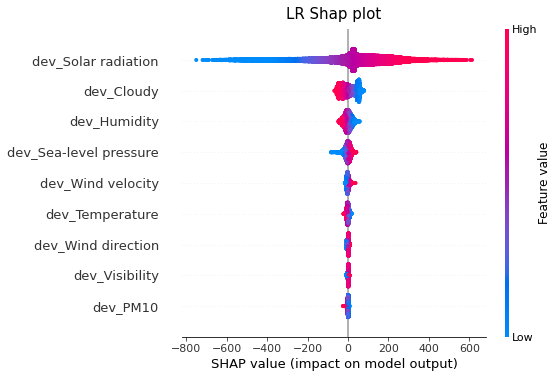

In [36]:
ShapPlot(**Shap_dic['dev_LR'])

Exact explainer: 21895it [2:31:55,  2.40it/s]


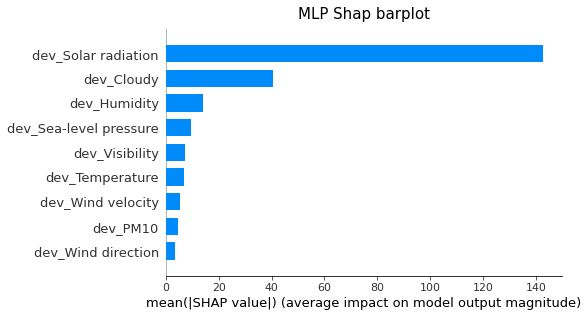

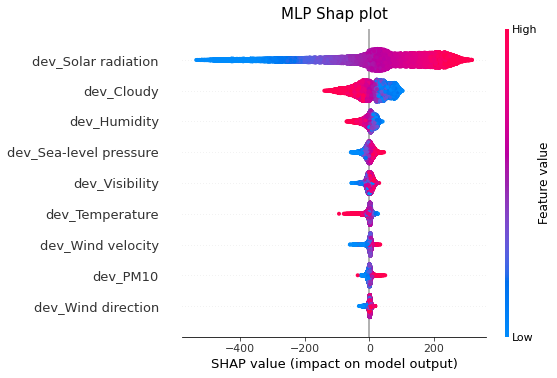

In [37]:
ShapPlot(**Shap_dic['dev_MLP'])

Exact explainer: 21895it [1:04:16,  5.66it/s]


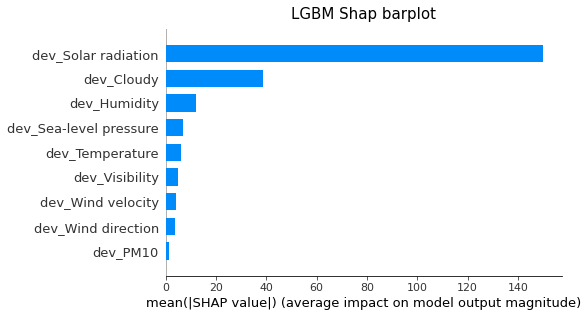

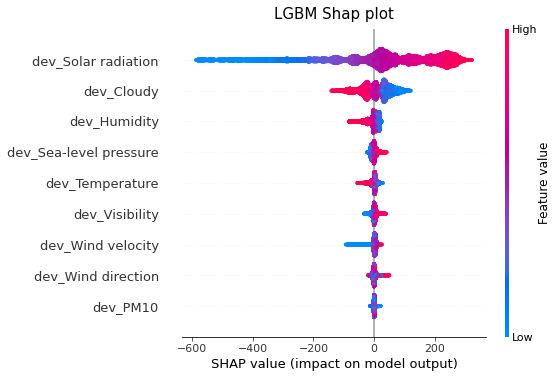

In [38]:
ShapPlot(**Shap_dic['dev_LGBM'])

# Plot

In [39]:
testmn

,mean_Photovoltaics
0,45.476273
1,247.181366
2,520.294013
3,741.026087
4,806.241988
...,...
4293,598.181194
4294,411.090811
4295,252.135584
4296,51.840000


In [40]:
data = Result_pred(df, pred_LR, pred_MLP, pred_LGBM, testmn)

In [41]:
data

,Area,Date,Month,Time,Photovoltaics,LR_Pred,MLP_Pred,LGBM_Pred,train_mean
0,전남 목포시,2019-01-01,1,9,7.32,-17.639677,-43.455930,-12.560642,45.476273
1,전남 목포시,2019-01-01,1,10,53.16,46.175896,13.463002,82.788332,247.181366
2,전남 목포시,2019-01-01,1,11,268.68,270.592137,233.124530,224.113728,520.294013
3,전남 목포시,2019-01-01,1,12,170.52,380.278009,386.646416,334.487119,741.026087
4,전남 목포시,2019-01-01,1,13,245.40,603.746187,565.363244,574.059326,806.241988
...,...,...,...,...,...,...,...,...,...
4293,전남 목포시,2019-12-31,12,14,1148.52,592.104951,570.700099,578.456540,598.181194
4294,전남 목포시,2019-12-31,12,15,830.88,637.064120,659.538208,658.819161,411.090811
4295,전남 목포시,2019-12-31,12,16,550.92,373.893982,395.007125,388.305848,252.135584
4296,전남 목포시,2019-12-31,12,17,74.28,153.397240,182.342911,144.346672,51.840000


In [42]:
data.rename(columns={'Photovoltaics' : 'PV'}, inplace=True)

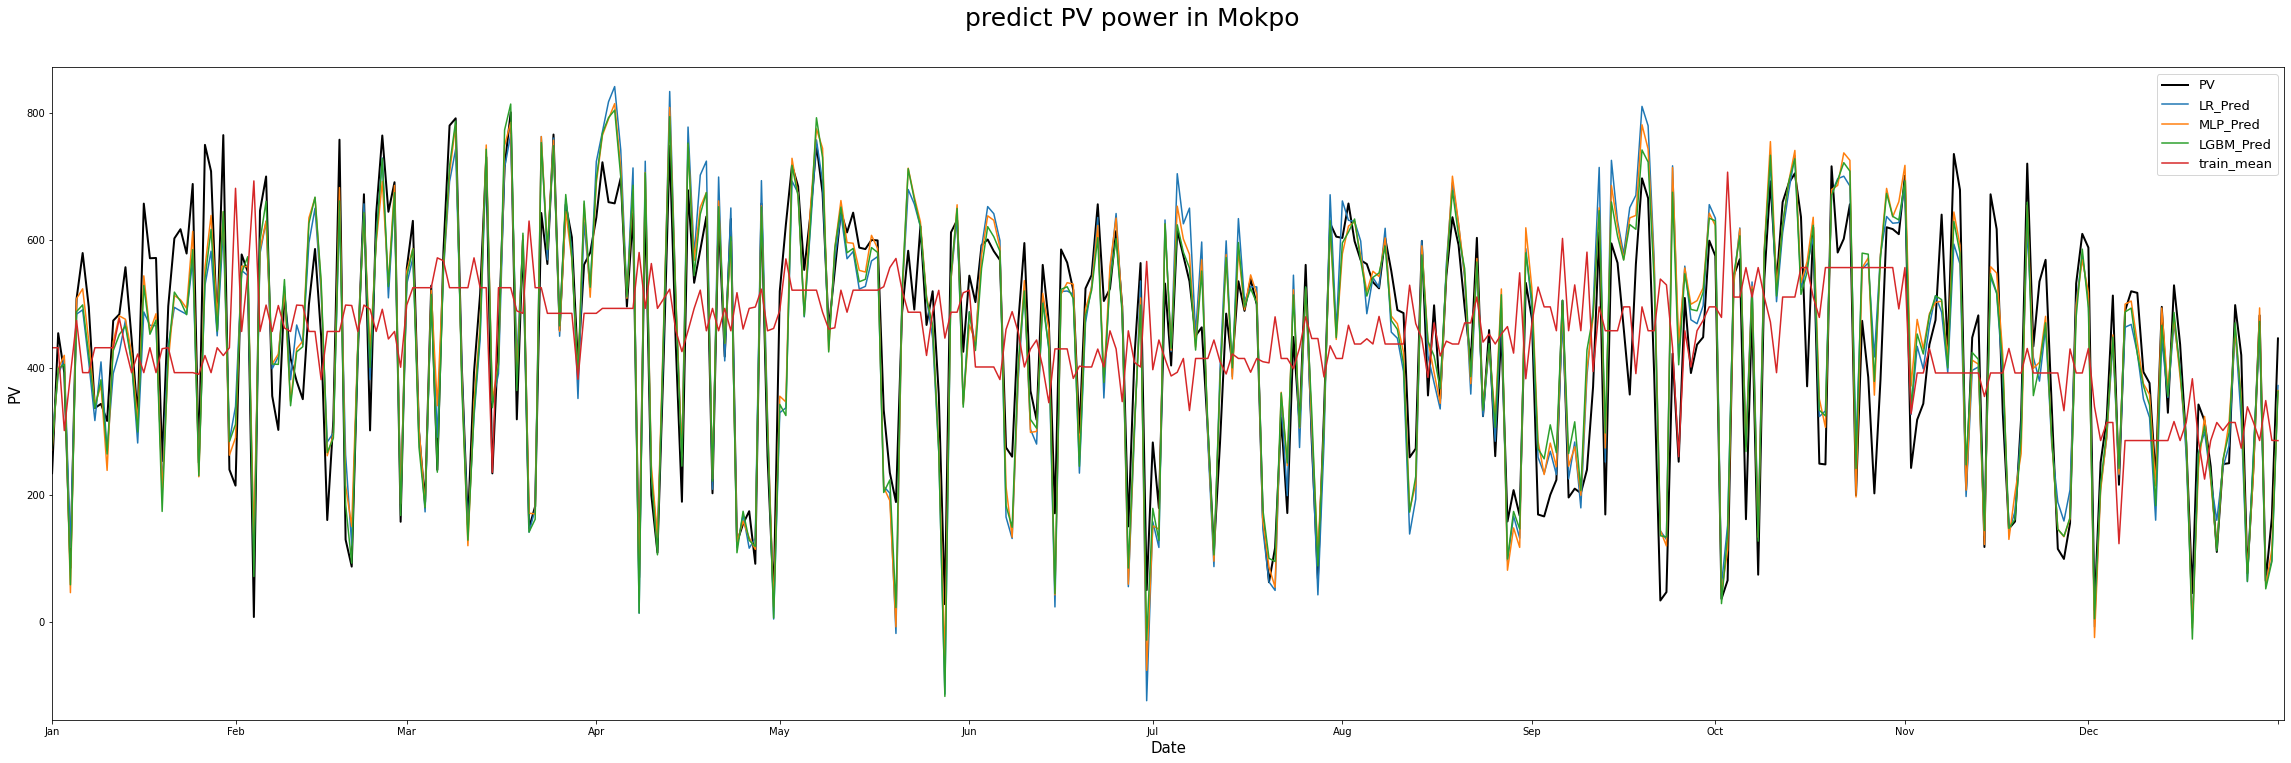

In [43]:
pred_cols = ['PV', 'LR_Pred', 'MLP_Pred', 'LGBM_Pred' , 'train_mean']
Plot_Result(data, 'Mokpo', pred_cols)